In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brica import Component, VirtualTimeScheduler, Timing

from matchernet.ekf import BundleEKFContinuousTime, MatcherEKF
from matchernet import fn
from matchernet import observer
from matchernet.state_space_model_2d import StateSpaceModel2Dim
from matchernet import utils
from matchernet.utils import print_flush

In [2]:
_with_brica = True

## Visualize

Visualize $ \ mu, \ Sigma, timestamp $ of bundle.

- $\mu$ trajectory
- X-axis decomposition
-  Y-axis decomposition

In [3]:
def visualize_bundle_rec(b, y_rec=None):
    mu_rec = b.record["mu"]
    sigma_rec = b.record["diagSigma"]
    time_stamp = b.record["time_stamp"]
    n_steps = mu_rec.shape[0]
    timestamp = np.array(range(0, n_steps))

    plt.subplot(221)
    plt.plot(mu_rec[:, 0], mu_rec[:, 1])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectory")

    plt.subplot(222)
    yd = mu_rec[:, 0] - sigma_rec[:, 0]
    yu = mu_rec[:, 0] + sigma_rec[:, 0]
    plt.fill_between(time_stamp, yd, yu, facecolor='y', alpha=0.5)
    plt.plot(time_stamp, mu_rec[:, 0])
    plt.ylabel("X")
    plt.xlabel("time")

    plt.subplot(224)
    yd = mu_rec[:, 1] - sigma_rec[:, 1]
    yu = mu_rec[:, 1] + sigma_rec[:, 1]
    plt.fill_between(time_stamp, yd, yu, facecolor='y', alpha=0.5)
    plt.plot(time_stamp, mu_rec[:, 1])
    plt.ylabel("Y")
    plt.xlabel("time")

    if y_rec is None:
        return
    else:
        plt.subplot(221)
        plt.scatter(y_rec[:, 0], y_rec[:, 1], s=2)
        plt.subplot(222)
        plt.scatter(time_stamp, y_rec[:, 0], s=2)
        plt.subplot(224)
        plt.scatter(time_stamp, y_rec[:, 1], s=2)

## State space model

Under a sufficiently small time step $\Delta t$, the above state-space model is discretized and linearized as follows:

$$
X_ {t + \Delta t} = F_t x_t + z_t, \\
Y_{t} = C_t x_t + w_t
$$

$ M_X, M_Y$ are the dimensions of the state variables and observed variables, respectively. Where $F_t = I + \Delta t A_t$, 
$$
A_t = \left. \frac{\partial f(x)}{\partial x}\right |_{x = x_t}, \\
C_t = \left. \frac{\partial g(x)}{\partial x}\right |_{x = x_t}
$$
Are Jacobian matrices for dynamics and observation functions, respectively.
$z_t \sim \mathcal{N}(0, \Sigma_z)$ and $w_t \sim \mathcal{N}(0, \Sigma_w)$ are system noise and observation noise, respectively. Is assumed.

In [4]:
mu0 = np.array([0, 1.0], dtype=np.float32)
A0 = np.array([[-0.1, 2], [-2, -0.1]], dtype=np.float32)
ey2 = np.eye(2, dtype=np.float32)

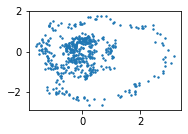

In [5]:
dt = 0.02
n_steps = 500

sm=StateSpaceModel2Dim(
    n_dim=2,
    A=A0,
    g=fn.LinearFn(utils.zeros(2)),
    sigma_w=0.1,
    sigma_z=0.1,
    x=mu0,
    y=utils.zeros((1, 2))
)
(x_rec, y_rec) = sm.simulation(n_steps, dt)

plt.figure(0)
plt.subplot(2, 2, 1)
plt.scatter(y_rec[:, 0], y_rec[:, 1], s=2)

## Bundle with Observer with no Matcher

Matcher prepares dummy, prepares observer and bundle appropriately, and checks the state transition of bundle.

In [6]:
def test_bundle_and_observer(dt, n_steps, y_rec):
    b0 = observer.Observer("b0", y_rec)
    b1 = BundleEKFContinuousTime("b1", 2, fn.LinearFn(A0))
    b1.state.data["mu"] = mu0
    b1.dt = dt
    dummy_input = {} # list of matchers (#matcher=0)
    
    for i in range(n_steps):
        b0(dummy_input)
        b1(dummy_input)
        y = b0.get_state()
        if i == 0:
            y_rec2 = y
        else:
            y_rec2 = np.vstack((y_rec2, y))

    timestamp = np.array(range(0, n_steps))
    visualize_bundle_rec(b1, y_rec2)

/Users/uchi_k/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/uchi_k/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/uchi_k/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes

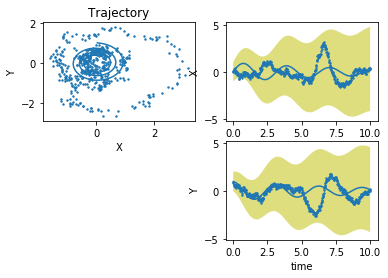

In [7]:
plt.figure(2)
test_bundle_and_observer(dt, n_steps, y_rec)
plt.pause(0.2)

## link a Bundle, a Observer, and a Matcher

Visualize the bundle trajectory in an extended kalman filter that includes all bundles, observers, and matchers, and also has links.

In [8]:
def test_MatcherEKF01(dt, n_steps, y_rec):
    """
    Run a matchernet of the following structure
    b0 --- m01 --- b1
    """

    b1 = observer.Observer("b1", y_rec)
    b1.obs_noise_covariance = 2 * ey2

    b0 = BundleEKFContinuousTime("b0", 2, fn.LinearFn(A0))
    b0.state.data["mu"] = mu0
    b0.dt = dt
    b0.state.data["mu"][1] = 2
    b0.state.data["Sigma"] = 2 * ey2

    m01 = MatcherEKF("m01", b0, b1)

    if _with_brica is False:
        for i in range(n_steps):
            print_flush("Step {}/{} with brica".format(i, n_steps))
            inputs_to_m01 = {"b0": b0.state, "b1": b1.state}
            results = m01(inputs_to_m01)
            inputs_to_b0 = {"m01": results["b0"]}
            s0 = b0(inputs_to_b0)
            inputs_to_b1 = {"m01": results["b1"]}
            s1 = b1(inputs_to_b1)
    else:
        s = VirtualTimeScheduler()

        bt = Timing(0, 1, 1)
        bm = Timing(1, 1, 1)

        s.add_component(b0.component, bt)
        s.add_component(b1.component, bt)
        s.add_component(m01.component, bm)

        for i in range(n_steps):
            print_flush("Step {}/{} with brica".format(i+1, n_steps))
            s.step()

#     visualize_bundle_rec(b0, y_rec)

In [9]:
_with_brica = True
plt.figure(3)
test_MatcherEKF01(dt, n_steps, y_rec)
plt.pause(0.2)

Step 500/500 with brica

<Figure size 432x288 with 0 Axes>